In [1]:
print("Name: {} \nAndrew ID: {}".format("Sparsh Tekriwal", "sparsht"))

Name: Sparsh Tekriwal 
Andrew ID: sparsht


In this notebook, I will analyze a set of reviews extracted from Amazon’s reviews for attributes of the Kindle that customers viewed positively and negatively, and will build a model to predict 5-star ratings based on the text in the review, and identify attributes of the reviews themselves that lead to other customers finding that review helpful.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/sparshtekriwal/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("kindle_reviews.csv", encoding='unicode_escape')

In [4]:
df.head(2)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username
0,AVphPmHuilAPnD_x3E5h,2016-03-31T21:08:24Z,2019-03-12T04:21:17Z,"Kindle Voyage E-reader, 6 High-Resolution Disp...",B00IOY8XWQ,Amazon,"eBook Readers,Electronics Features,Walmart for...",Electronics,https://images-na.ssl-images-amazon.com/images...,"amazon/b00ioy8xwq,848719040104,kindlevoyageere...",...,"2017-07-07T00:00:00Z,2018-05-28T00:00:00Z,2017...",NaN,True,NaN,0,5,https://reviews.bestbuy.com/3545/9302088/revie...,I bought this so i can save all of my books. I...,"A bit small, but very useful!!",Goldfish
1,AVphPmHuilAPnD_x3E5h,2016-03-31T21:08:24Z,2019-03-12T04:21:17Z,"Kindle Voyage E-reader, 6 High-Resolution Disp...",B00IOY8XWQ,Amazon,"eBook Readers,Electronics Features,Walmart for...",Electronics,https://images-na.ssl-images-amazon.com/images...,"amazon/b00ioy8xwq,848719040104,kindlevoyageere...",...,"2017-07-07T00:00:00Z,2018-05-28T00:00:00Z,2017...",NaN,True,NaN,0,5,http://reviews.bestbuy.com/3545/9302088/review...,I bought this as a gift. I think it is pretty ...,a decent gift,Zigpig


In [5]:
df.shape

(844, 23)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844 entries, 0 to 843
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   844 non-null    object 
 1   dateAdded            844 non-null    object 
 2   dateUpdated          844 non-null    object 
 3   name                 844 non-null    object 
 4   asins                844 non-null    object 
 5   brand                844 non-null    object 
 6   categories           844 non-null    object 
 7   primaryCategories    844 non-null    object 
 8   imageURLs            844 non-null    object 
 9   keys                 844 non-null    object 
 10  manufacturer         844 non-null    object 
 11  manufacturerNumber   844 non-null    object 
 12  reviews.date         844 non-null    object 
 13  reviews.dateSeen     844 non-null    object 
 14  reviews.didPurchase  0 non-null      float64
 15  reviews.doRecommend  844 non-null    boo

Lets drop columns reviews.didPurchase and reviews.id as they are completely null

In [7]:
df.drop(["reviews.didPurchase", "reviews.id"], axis=1, inplace=True)

In [8]:
df.describe(include=['int64','float']).transpose()

,count,mean,std,min,25%,50%,75%,max
reviews.numHelpful,844.0,1.668246,4.673835,0.0,0.0,0.0,1.0,72.0
reviews.rating,844.0,4.689573,0.652278,1.0,5.0,5.0,5.0,5.0


In [9]:
df.describe(include=['boolean']).transpose()

,count,unique,top,freq
reviews.doRecommend,844,2,True,815


In [10]:
df.describe(include=['object']).transpose()

,count,unique,top,freq
id,844,9,AVphPmHuilAPnD_x3E5h,505
dateAdded,844,6,2016-03-31T21:08:24Z,505
dateUpdated,844,7,2019-03-12T04:21:17Z,505
name,844,9,"Kindle Voyage E-reader, 6 High-Resolution Disp...",505
asins,844,9,B00IOY8XWQ,505
brand,844,1,Amazon,844
categories,844,8,"eBook Readers,Electronics Features,Walmart for...",505
primaryCategories,844,3,Electronics,560
imageURLs,844,9,https://images-na.ssl-images-amazon.com/images...,505
keys,844,9,"amazon/b00ioy8xwq,848719040104,kindlevoyageere...",505


## Task 1

True     815
False     29
Name: reviews.doRecommend, dtype: int64


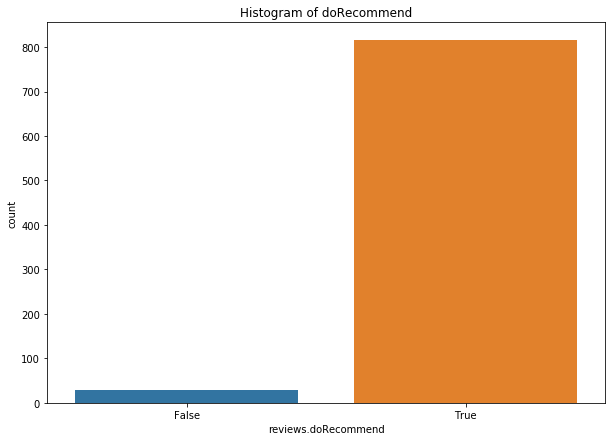

In [11]:
# Exploring Column reviews.doRecommend
df['reviews.doRecommend']
print(df['reviews.doRecommend'].value_counts())

plt.figure(figsize= (10,7))
sns.countplot(df['reviews.doRecommend'])
plt.title('Histogram of doRecommend')
plt.show()

count    844.000000
mean       4.689573
std        0.652278
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: reviews.rating, dtype: float64

Value Counts
5    642
4    164
3     23
2      8
1      7
Name: reviews.rating, dtype: int64


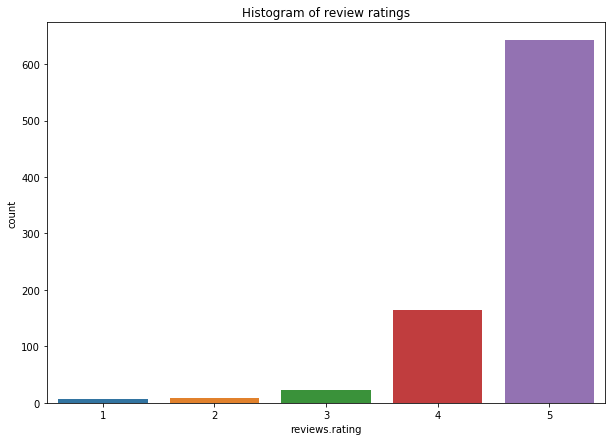

In [12]:
# Exploring Column 'reviews.rating'
col_reviewsRating = df.loc[:, 'reviews.rating']
print(col_reviewsRating.describe())
print()

print("Value Counts")
print(df['reviews.rating'].value_counts())

plt.figure(figsize= (10,7))
sns.countplot(df['reviews.rating'])
plt.title('Histogram of review ratings')
plt.show()

count    844.000000
mean       1.668246
std        4.673835
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       72.000000
Name: reviews.numHelpful, dtype: float64

Value Counts
0     495
1     152
2      50
3      38
5      20
4      18
6      15
8      14
7      11
9       6
10      4
11      3
16      3
19      2
72      1
12      1
49      1
14      1
15      1
18      1
23      1
25      1
27      1
35      1
36      1
39      1
13      1
Name: reviews.numHelpful, dtype: int64


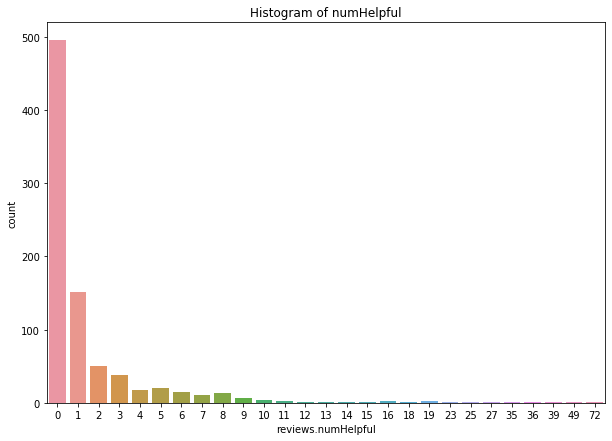

In [13]:
# Exploring Column 'reviews.numHelpful'
col_numHelpful = df.loc[:, 'reviews.numHelpful']
print(col_numHelpful.describe())
print()

print("Value Counts")
print(df['reviews.numHelpful'].value_counts())

plt.figure(figsize= (10,7))
sns.countplot(df['reviews.numHelpful'])
plt.title('Histogram of numHelpful')
plt.show()

Q. Do you see any issues in using these fields as outcome (target) variables?

Yes. I see two main issues:

- The doRecommend column has boolean values and will need to be binarized before it can be fed into a classification algorithm such as Logistic Regression

- The ratings and doRecommend columns have multiple classes that are highly imbalanced. We might need to use an algirithm like SMOTE to reduce biases due to this class imbalance

## Task 2
Prepare the text of the reviews in the reviews.text field for analysis by eliminating stopwords. What are the top 10 mostfrequent words? What are the top 10 nouns? What are the top ten adjectives?

In [14]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import string

# nltk.download('stopwords')
    
stop = stopwords.words('english')

In [15]:
df["reviews.cleanText"] = df["reviews.text"].apply(lambda x: " ". join([WordNetLemmatizer().lemmatize(word.lower()) 
                                    for word in word_tokenize(x) 
                                    if word.lower() not in stop 
                                    and word not in list(string.punctuation) 
                                    and len(word)>2]))
# .str.replace('[^\w\s]','')

### 10 most frequent words

In [16]:
#Reference : https://stackoverflow.com/questions/29903025/count-most-frequent-100-words-from-sentences-in-dataframe-pandas
from collections import Counter
Counter(" ".join(df["reviews.cleanText"]).split()).most_common(10)


[('kindle', 618),
 ('love', 269),
 ('light', 260),
 ('great', 237),
 ('reading', 232),
 ('screen', 232),
 ('voyage', 227),
 ('read', 227),
 ('one', 213),
 ('easy', 205)]

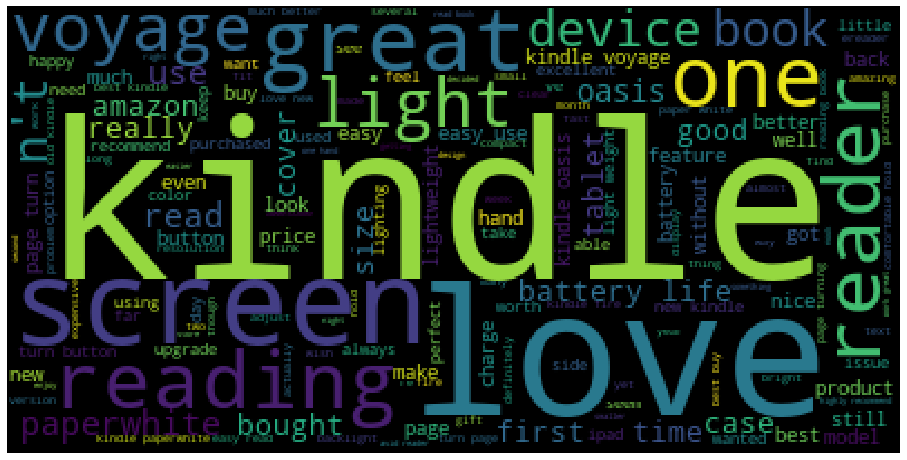

In [17]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black", max_words=300).generate(" ".join(df["reviews.cleanText"]))
plt.figure(figsize=(16,9))
plt.clf()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Top 10 Nouns

In [18]:
from nltk.tag import pos_tag
nouns = [tup[0] for tup in pos_tag(" ".join(df["reviews.cleanText"]).split(" ")) if tup[1] == 'NN' or tup[1] =='NNS' or tup[1] == 'NNP' or tup[1] == 'NNPS']
Counter(nouns).most_common(10)                                                                                                                                   

[('voyage', 217),
 ('book', 194),
 ('page', 194),
 ('kindle', 176),
 ('reader', 146),
 ('screen', 144),
 ('battery', 140),
 ('device', 138),
 ('oasis', 125),
 ('use', 123)]

### Top 10 Adjectives

In [19]:
adj = [tup[0] for tup in pos_tag(" ".join(df["reviews.cleanText"]).split(" ")) if tup[1] == 'JJ' or tup[1] =='JJR' or tup[1] == 'JJS']
Counter(adj).most_common(10)     

[('kindle', 308),
 ('great', 237),
 ('easy', 201),
 ('light', 164),
 ('best', 133),
 ('new', 113),
 ('screen', 82),
 ('good', 81),
 ('paperwhite', 77),
 ('much', 76)]

## Task 3

What are the top ten most frequent words in reviews that do not recommend purchase
of the Kindle? 

Here it makes sense to get rid of brand and product name such as "kindle" and "amazon" as they don't convey any special meaning

In [20]:
df_false = df[df['reviews.doRecommend'] == False]
Counter(" ".join(df_false["reviews.cleanText"]).split()).most_common(10)

[('kindle', 20),
 ("n't", 17),
 ('amazon', 14),
 ('device', 14),
 ('voyage', 10),
 ('would', 10),
 ('light', 10),
 ('page', 9),
 ('buy', 8),
 ('one', 8)]

## Task 4

### Random Forest Classifier

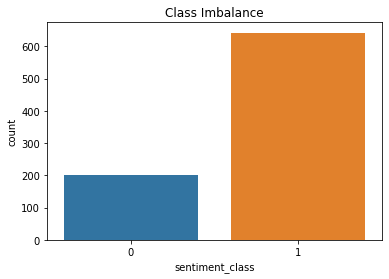

Stratifying data while splitting of Train and Test

Training Set has 449 Positive Labels and 141 Negative Labels
Test Set has 193 Positive Labels and 61 Negative Labels

              precision    recall  f1-score   support

           0       0.94      0.28      0.43        61
           1       0.81      0.99      0.90       193

    accuracy                           0.82       254
   macro avg       0.88      0.64      0.66       254
weighted avg       0.84      0.82      0.78       254

ROC AUC Score: 0.7478977320988702
Train accuracy of model (R^2) 1.0
Test accuracy of model (R^2) 0.82


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.7)
tfidf_features = tfidf.fit_transform(df["reviews.cleanText"])


# Binarising Output column
df["sentiment_class"] = df["reviews.rating"].apply(lambda x: 1 if x==5 else 0)
plt.figure(figsize= (6,4))
sns.countplot(df["sentiment_class"], )
plt.title('Class Imbalance')
plt.show()

# Random Forest Classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

X_train, X_test, y_train, y_test = train_test_split(tfidf_features, df["sentiment_class"], stratify=df["sentiment_class"], test_size=0.3, random_state=1)

print("Stratifying data while splitting of Train and Test\n")
print("Training Set has {} Positive Labels and {} Negative Labels".format(sum(y_train), len(y_train) - sum(y_train)))
print("Test Set has {} Positive Labels and {} Negative Labels".format(sum(y_test), len(y_test) - sum(y_test)))
print()

rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)
print(classification_report(y_test , y_pred))

print("ROC AUC Score: {}".format(roc_auc_score(y_test, y_pred_proba[:, -1])))


print("Train accuracy of model (R^2)" ,str(rf.score(X_train, y_train) ))
print("Test accuracy of model (R^2)" ,str(np.round(rf.score(X_test, y_test),2 )))

### Confusion Matrix

In [22]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted   0    1  All
Actual                 
0          17   44   61
1           1  192  193
All        18  236  254


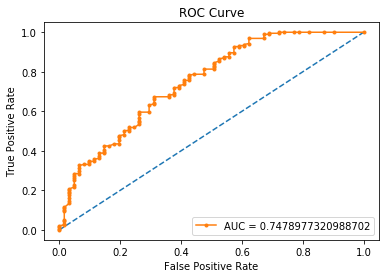

In [23]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, y_pred_proba[:, -1])
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, y_pred_proba[:, -1])}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

## Task 5

Create a model that will predict when at least two customer will find a review helpful.
Evaluate the accuracy of your model 

In [24]:
df["helpfulOrNot"] = np.where(df["reviews.numHelpful"] >=2 ,1 , 0) # 1 when numHelpful >=2 else 0

In [25]:
# Converting tfidf into a dataFrame
df_new = pd.DataFrame(tfidf_features.todense())

# adding columns doRecommend and ratings as additinal features to the tfidf 
df_new['doRecommend'] = df['reviews.doRecommend'].apply(lambda x: int(x))
df_new['rating'] = df['reviews.rating']

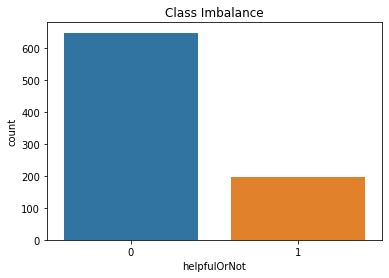

In [26]:
plt.figure(figsize= (6,4))
sns.countplot(df["helpfulOrNot"], )
plt.title('Class Imbalance')
plt.show()

In [27]:
#Random Forest using stritatified training and test data 

X_train, X_test, y_train, y_test = train_test_split(df_new, df["helpfulOrNot"], stratify=df["sentiment_class"], test_size=0.3, random_state=1)

print("Stratifying data while splitting of Train and Test\n")
print("Training Set has {} Positive Labels and {} Negative Labels".format(sum(y_train), len(y_train) - sum(y_train)))
print("Test Set has {} Positive Labels and {} Negative Labels".format(sum(y_test), len(y_test) - sum(y_test)))
print()


rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)
print(classification_report(y_test , y_pred))

print("ROC AUC Score: {}".format(roc_auc_score(y_test, y_pred_proba[:, -1])))


print("Train accuracy of model (R^2)" ,str(rf.score(X_train, y_train) ))
print("Test accuracy of model (R^2)" ,str(np.round(rf.score(X_test, y_test),2 )))

Stratifying data while splitting of Train and Test

Training Set has 142 Positive Labels and 448 Negative Labels
Test Set has 55 Positive Labels and 199 Negative Labels

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       199
           1       1.00      0.35      0.51        55

    accuracy                           0.86       254
   macro avg       0.92      0.67      0.72       254
weighted avg       0.88      0.86      0.83       254

ROC AUC Score: 0.7582457743261763
Train accuracy of model (R^2) 1.0
Test accuracy of model (R^2) 0.86


In [28]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

Predicted    0   1  All
Actual                 
0          199   0  199
1           36  19   55
All        235  19  254


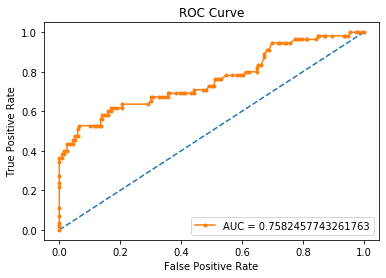

In [29]:
false_pos_rate, true_pos_rate, proba = roc_curve(y_test, y_pred_proba[:, -1])
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, y_pred_proba[:, -1])}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")